In [1]:
import torch
import numpy as np
from models.bertmodel import BERT
from trainers.bertmodel_trainer import BERT_Trainer
from get_modules.get_loaders import get_loaders

class Config:
    def __init__(self):
        self.gpu_id = 0 if torch.cuda.is_available() else -1
        self.batch_size = 64
        self.n_epochs = 2
        self.verbose = 2
        self.learning_rate = 0.001
        self.optimizer = "adam"
        self.dataset_name = "assistments09"
        self.crit = "binary_cross_entropy"
        self.max_seq_len = 100
        self.num_encoder = 12
        self.hidden_size = 512
        self.num_head = 16
        self.output_size = 1
        self.dropout_p = .1
        self.use_leakyrelu = True
        self.grad_acc = False
        self.grad_acc_iter = 2
        self.fivefold = False
config = Config()

device = torch.device('cuda:0')
train_loader, valid_loader, test_loader, num_q, num_r, num_pid, num_diff, num_ap, num_pd, num_sm = get_loaders(config)

model = BERT(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_ap=num_ap,
    num_pd=num_pd,
    num_sm=num_sm,
    hidden_size=config.hidden_size,
    output_size=config.output_size,
    num_head=config.num_head,
    num_encoder=config.num_encoder,
    max_seq_len=config.max_seq_len,
    device=device,
    use_leakyrelu=config.use_leakyrelu,
    dropout_p=config.dropout_p
).to(device)

model_bert_path = '../model_records/0.843393084533255_3_9_10_59_assistments09model.pth'
model_dict = torch.load(model_bert_path)
model.load_state_dict(model_dict['model'])

C:\Users\Jindi\anaconda3\envs\ktresearch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<All keys matched successfully>

In [2]:
import torch
from copy import deepcopy

from torch.nn.functional import one_hot
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from random import random, randint

from utils import EarlyStopping

# For Test MLM
# The last of seq will be changed to the <MASK>
def Mlm4BertTest(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)

        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        # last index of real_r_seq
        mlm_idx = real_r_seq_len - 1
        # last index get a <MASK>, <MASK> is 2
        real_r_seq[mlm_idx] = 2

        pad_len = r_len - real_r_seq_len
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) # <PAD> is 3
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        mlm_r_seqs.append(pad_r_seq)

        mlm_zeros = np.zeros(shape=(r_len, ))
        mlm_zeros[mlm_idx] = 1
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)


class Tester():
    def __init__(
        self, 
        model, 
        n_epochs, 
        device, 
        num_q, 
        crit, 
        max_seq_len
        ):
        self.model = model.to(device)
        self.n_epochs = n_epochs
        self.device = device
        self.num_q = num_q
        self.crit = crit
        self.max_seq_len = max_seq_len
        
        # save the vis
        self.emb_idx = [] # q, r, pid, diff
        self.emb_vec = []
        
    def _get_emb(self, q, r, pid, ap, pd, sm):
        '''generate emb sample from data
        |emb_vec| = [bs, num_seq, emb_dim]
        '''
        if ap:
            emb = self.model.emb_q(q) + self.model.emb_r(r) + self.model.emb_pid(pid) + self.model.emb_ap(ap) \
                + self.model.emb_pd(pd) + self.model._positional_embedding(q) + self.model.emb_sm(sm)
        else:
            emb = self.model.emb_q(q) + self.model.emb_r(r) + self.model.emb_pid(pid)+ self.model._positional_embedding(q)

        return emb
        
    def _save_emb(self, data, emb):
        '''save emb to self.~
        '''
        # organize data, hook to easily get the attr
        batch = [torch.stack([q_seqs.type(torch.long), 
                              r_seqs.type(torch.long), 
                              pid_seqs.type(torch.long), 
                              ap_seqs.type(torch.long), 
                              pd_seqs.type(torch.long), 
                              sm_seqs.type(torch.long), 
                              mask_seqs.type(torch.long)], dim = 1) for q_seqs, r_seqs, pid_seqs, ap_seqs, pd_seqs, sm_seqs, mask_seqs in zip(*data)]
        
        # save hook to self.~
        for seq_idx, seq in enumerate(batch):
            for sample_idx, sample in enumerate(seq):
                q    = int(sample[0])
                r    = int(sample[1])
                pid  = int(sample[2])
                ap   = int(sample[3])
                pd   = int(sample[4])
                sm   = int(sample[5])
                is_mask = bool(sample[6])                
                
                if is_mask is True:
                    # save filter
                    self.emb_idx.append([q, r, pid, ap, pd, sm])
                    self.emb_vec.append(emb[seq_idx, sample_idx])
        
    def test(self, test_loader, a_features):
        with torch.no_grad():
            self.model = self.model.to(self.device)
            for data in tqdm(test_loader):
                self.model.eval()
                q_seqs, r_seqs, pid_seqs, ap_seqs, pd_seqs, sm_seqs, mask_seqs = data
                
                q_seqs = q_seqs.to(self.device)
                r_seqs = r_seqs.to(self.device)
                pid_seqs = pid_seqs.to(self.device)
                ap_seqs = ap_seqs.to(self.device)
                pd_seqs = pd_seqs.to(self.device)
                sm_seqs = sm_seqs.to(self.device)
                mask_seqs = mask_seqs.to(self.device)

                real_seqs = r_seqs.clone()

                mlm_r_seqs, mlm_idxs = Mlm4BertTest(r_seqs, mask_seqs)

                mlm_r_seqs = mlm_r_seqs.to(self.device)
                mlm_idxs = mlm_idxs.to(self.device)

                emb = self._get_emb(q    = q_seqs.type(torch.long), 
                                    r    = r_seqs.type(torch.long), 
                                    pid  = pid_seqs.type(torch.long), 
                                    ap   = ap_seqs.type(torch.long) if a_features else None,
                                    pd   = pd_seqs.type(torch.long) if a_features else None,
                                    sm   = sm_seqs.type(torch.long) if a_features else None)
                self._save_emb(data, emb.detach().clone())
        return

In [3]:
device = torch.device('cpu')
model.device = torch.device('cpu')
model = model.to(device)

trainer = Tester(
    model=model,
    n_epochs=config.n_epochs,
    device=device,
    num_q=num_q,
    crit=config.crit,
    max_seq_len=config.max_seq_len,
)

a_features = False
auc_score = trainer.test(test_loader, a_features)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


In [4]:
r_idxs    = np.array([emb_idx[1] for emb_idx in trainer.emb_idx])

q_idxs    = np.array([emb_idx[0] for emb_idx in trainer.emb_idx])
pid_idxs  = np.array([emb_idx[2] for emb_idx in trainer.emb_idx])
ap_idxs  = np.array([emb_idx[3] for emb_idx in trainer.emb_idx])
pd_idxs  = np.array([emb_idx[4] for emb_idx in trainer.emb_idx])
sm_idxs  = np.array([emb_idx[5] for emb_idx in trainer.emb_idx])

correct_q_idxs    = np.array([emb_idx[0] for emb_idx in trainer.emb_idx])[r_idxs == 1]
correct_pid_idxs  = np.array([emb_idx[2] for emb_idx in trainer.emb_idx])[r_idxs == 1]
correct_ap_idxs  = np.array([emb_idx[3] for emb_idx in trainer.emb_idx])[r_idxs == 1]
correct_pd_idxs  = np.array([emb_idx[4] for emb_idx in trainer.emb_idx])[r_idxs == 1]
correct_sm_idxs  = np.array([emb_idx[5] for emb_idx in trainer.emb_idx])[r_idxs == 1]

(46281, 512)


[]

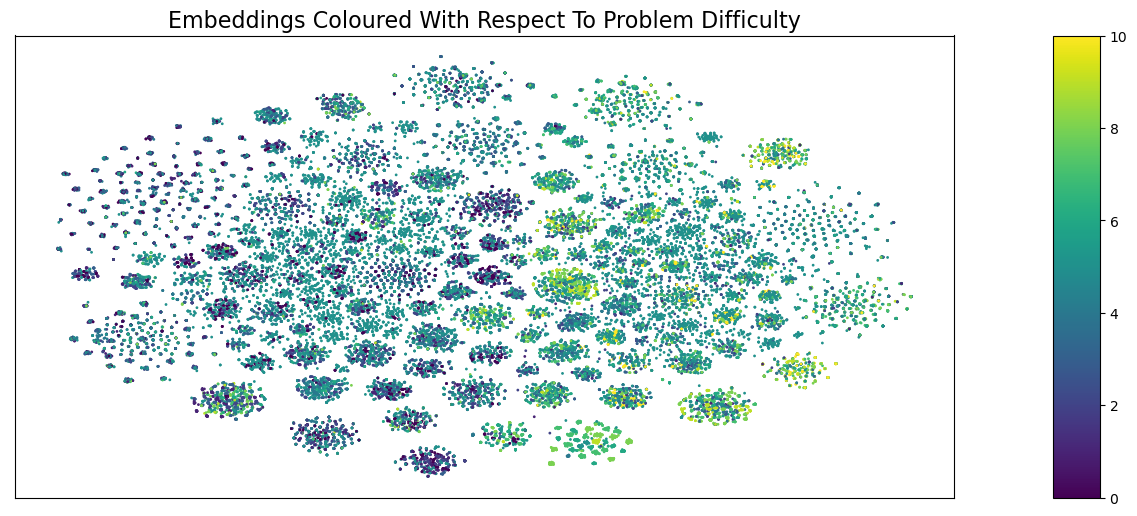

In [5]:
# tsne
import numpy as np
import pickle
from sklearn.manifold import TSNE

emb_dict_tsne = {
    'X_total' : [],
    'X_corr' : [],
}

emb_vec = np.array([emb_vec.tolist() for emb_vec in trainer.emb_vec])
print(emb_vec.shape)

X_embedded = TSNE(n_components=2, init='random', n_jobs=16).fit_transform(emb_vec)
X_embedded_corrected = TSNE(n_components=2, init='random', n_jobs=16).fit_transform(emb_vec[r_idxs == 1])

emb_dict_tsne['X_total'] = X_embedded
emb_dict_tsne['X_corr']  = X_embedded_corrected    
    
# with open('../model_records/emb_tsne.pickle', 'wb') as handle:
#     pickle.dump(emb_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

import matplotlib.cm as cm
import matplotlib.pyplot as plt

# figure
# total sample , diff 
plt.rcParams["figure.figsize"] = (14, 6)
emb_dict = emb_dict_tsne

# total_or_corr = 'X_corr'
total_or_corr = 'X_total'
# color_idx = sm_idxs if total_or_corr == 'X_total' else correct_sm_idxs
# color_idx = ap_idxs if total_or_corr == 'X_total' else correct_ap_idxs
color_idx = pd_idxs if total_or_corr == 'X_total' else correct_pd_idxs

fig, (ax0, cax) = plt.subplots(ncols = 2, gridspec_kw={"width_ratios":[1, 0.05]})
axs = [ax0]

x_no = axs[0].scatter(emb_dict[total_or_corr][:, 0], emb_dict[total_or_corr][:, 1], c=color_idx, s = 1)
axs[0].set_title('Embeddings Coloured With Respect To Problem Difficulty', fontsize = 16)

fig.colorbar(x_no, cax=cax)

axs[0].set_xticks([])
axs[0].set_yticks([])

# plt.show()
# plt.savefig('../model_records/figure_4.pdf')

[]

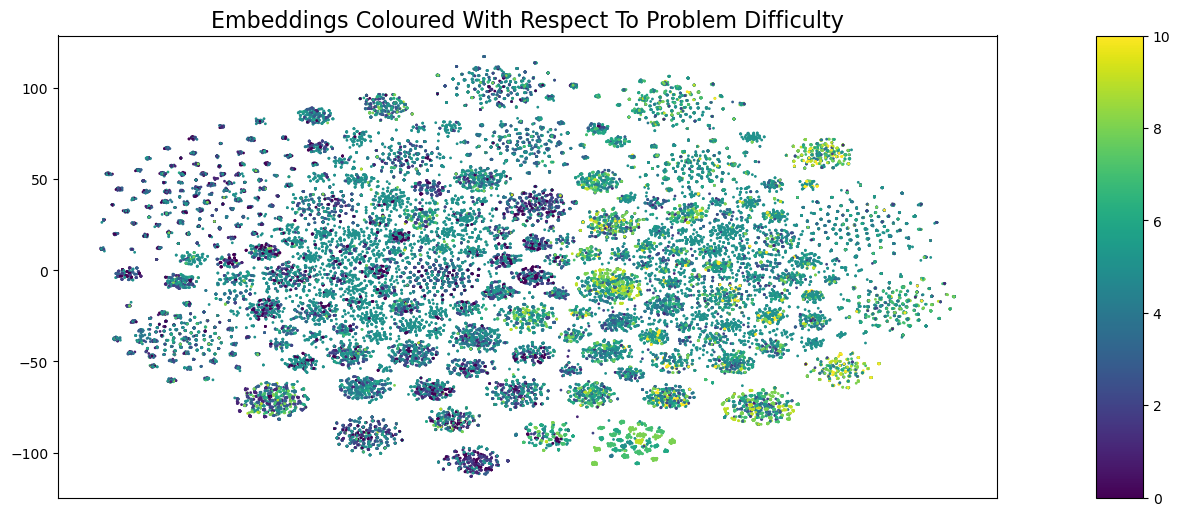

In [6]:
color_idx = pd_idxs if total_or_corr == 'X_total' else correct_pd_idxs

fig, (ax0, cax) = plt.subplots(ncols = 2, gridspec_kw={"width_ratios":[1, 0.05]})
axs = [ax0]

x_no = axs[0].scatter(emb_dict[total_or_corr][:, 0], emb_dict[total_or_corr][:, 1], c=color_idx, s = 1)
axs[0].set_title('Embeddings Coloured With Respect To Problem Difficulty', fontsize = 16)

fig.colorbar(x_no, cax=cax)

axs[0].set_xticks([])

[]

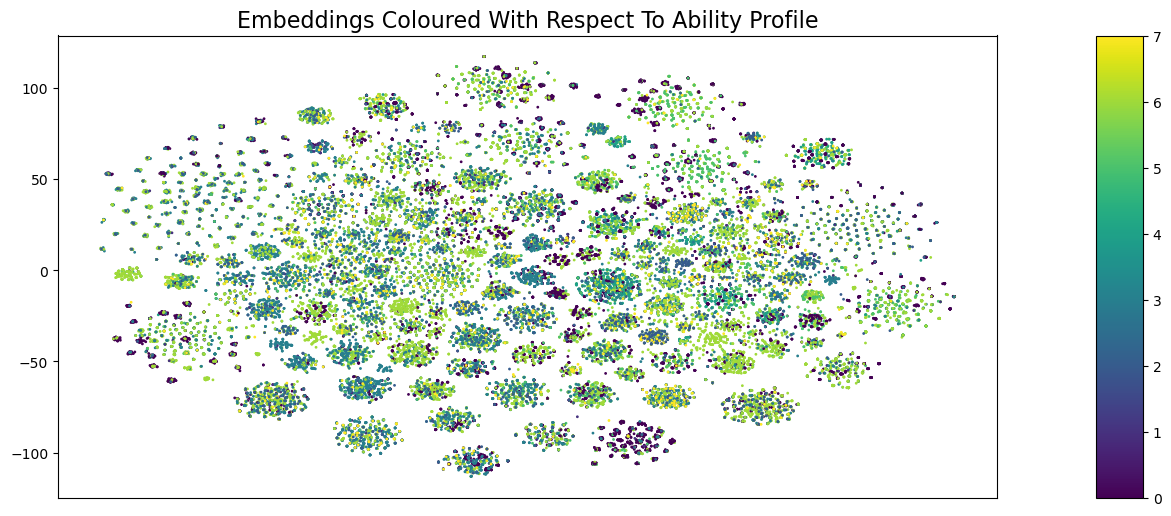

In [7]:
color_idx = ap_idxs if total_or_corr == 'X_total' else correct_ap_idxs

fig, (ax0, cax) = plt.subplots(ncols = 2, gridspec_kw={"width_ratios":[1, 0.05]})
axs = [ax0]

x_no = axs[0].scatter(emb_dict[total_or_corr][:, 0], emb_dict[total_or_corr][:, 1], c=color_idx, s = 1)
axs[0].set_title('Embeddings Coloured With Respect To Ability Profile', fontsize = 16)

fig.colorbar(x_no, cax=cax)

axs[0].set_xticks([])

[]

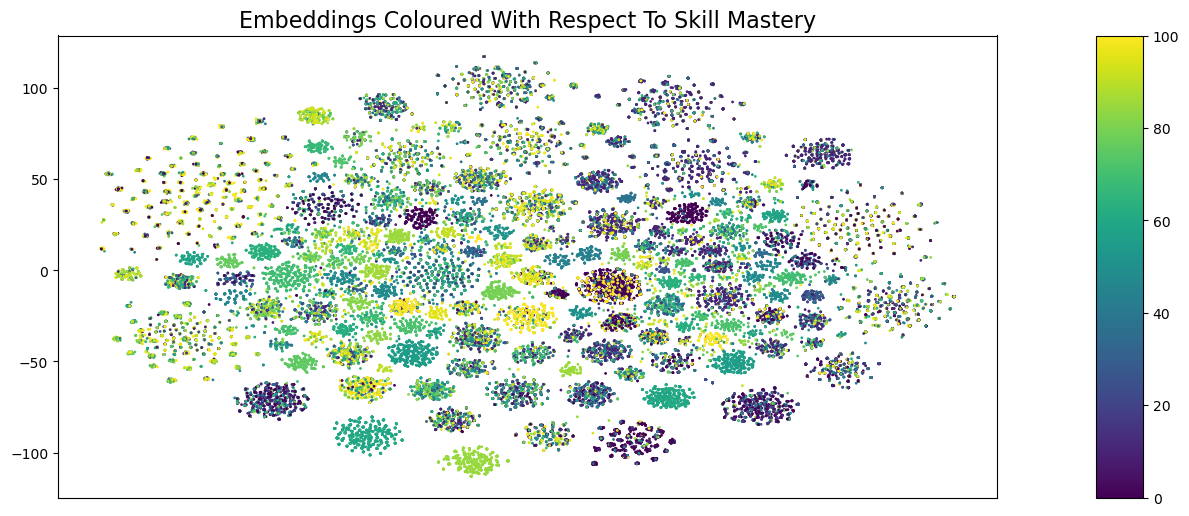

In [8]:
color_idx = sm_idxs if total_or_corr == 'X_total' else correct_sm_idxs

fig, (ax0, cax) = plt.subplots(ncols = 2, gridspec_kw={"width_ratios":[1, 0.05]})
axs = [ax0]

x_no = axs[0].scatter(emb_dict[total_or_corr][:, 0], emb_dict[total_or_corr][:, 1], c=color_idx, s = 1)
axs[0].set_title('Embeddings Coloured With Respect To Skill Mastery', fontsize = 16)

fig.colorbar(x_no, cax=cax)

axs[0].set_xticks([])